In [283]:
!pip install -U statsmodels

In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from scipy.stats import boxcox

In [285]:
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tsa.seasonal import seasonal_decompose

In [286]:
import itertools

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [287]:
hate_crime = pd.read_csv("hate_crime.csv", parse_dates=True)

In [288]:
df = hate_crime[['incident_id','incident_date']].copy()

In [289]:
df['incident_dttm'] = pd.to_datetime(df['incident_date'])


In [290]:
# Grouping/ Aggregating/ Resampling

In [291]:
# Method 1: group by to get daily counts

In [292]:
aggs = df.groupby('incident_dttm')[['incident_id']].count().rename(columns={'incident_id': 'counts'}).reset_index().set_index('incident_dttm')

In [293]:
# Method 2: resample for monthly data

In [294]:
monthly_data = aggs.resample(rule='M').sum()

In [295]:
monthly_data.index.freq

<MonthEnd>

In [296]:
# Transforming Data
# Log Count will help with heteroskedasticity, creating a more normal distribution

In [297]:
monthly_data['LogCount'] = np.log(monthly_data['counts'])

<Axes: xlabel='incident_dttm'>

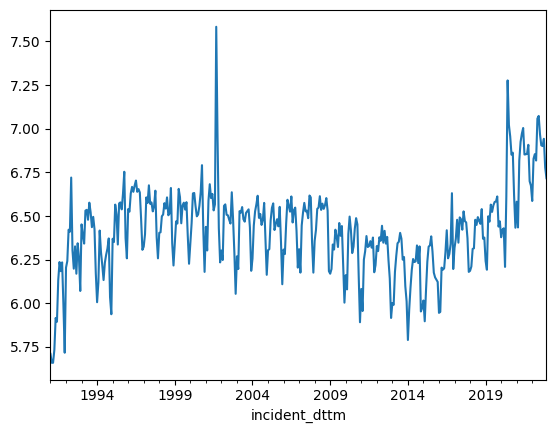

In [298]:
monthly_data['LogCount'].plot()

In [299]:
data, lam = boxcox(monthly_data['counts'])

In [300]:
lam

-0.14845885327542813

In [301]:
monthly_data['boxcox'] = data

<Axes: >

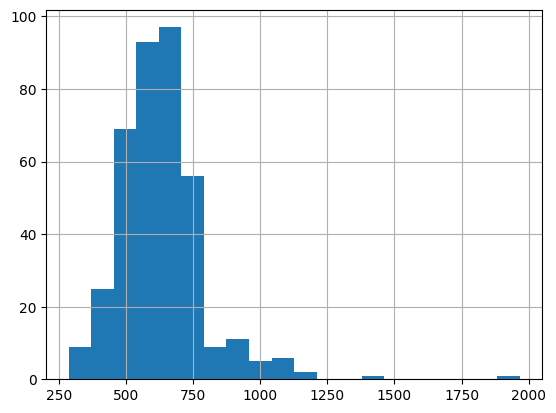

In [302]:
monthly_data['counts'].hist(bins=20)

<Axes: >

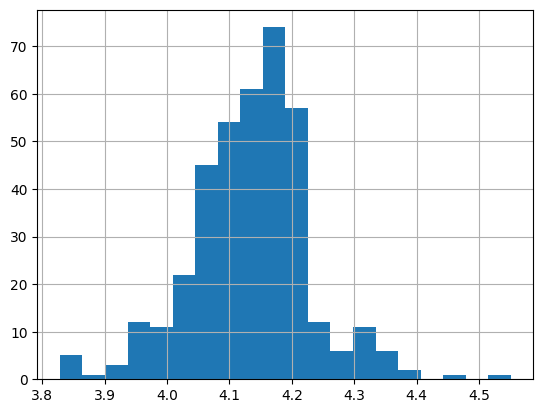

In [303]:
monthly_data['boxcox'].hist(bins=20)

<Axes: >

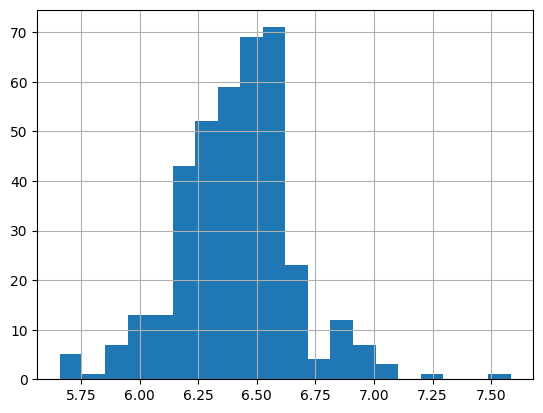

In [396]:
monthly_data['LogCount'].hist(bins=20)

In [304]:
### Descriptive Metrics

In [305]:
monthly_data['SMA-6'] = monthly_data['counts'].rolling(6).mean()

In [307]:
monthly_data['ewma-6'] = monthly_data['counts'].ewm(span=6, adjust=False).mean()

In [309]:
### Plotting

<Axes: xlabel='incident_dttm'>

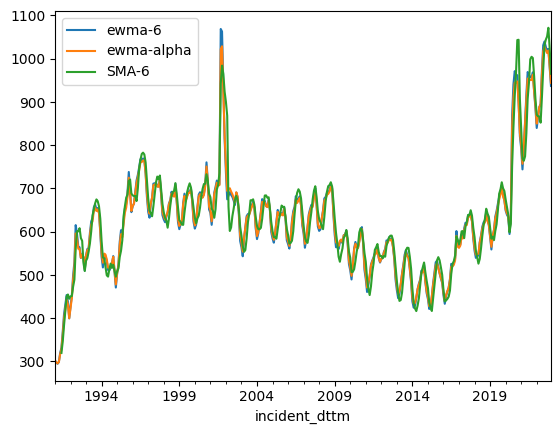

In [311]:
monthly_data[['ewma-6','SMA-6']].plot()

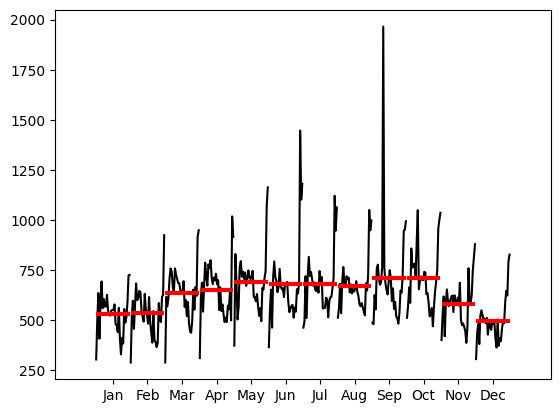

In [312]:
month_plot(monthly_data['counts']);
# See below that there is some seasonality

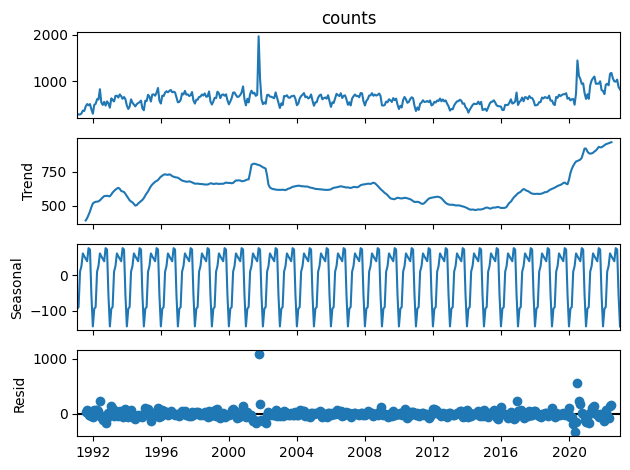

In [313]:
seasonal_decompose(monthly_data['counts'], model='additive', period=12).plot();

In [314]:
seasonal = seasonal_decompose(monthly_data['counts'], model='additive', period=12)

In [315]:
## Predictive Modeling

In [316]:
## Counts modeled

In [317]:
## Note The Simple Exponential Smoothing only applies to series without trend or seasonality
## This data set has both, as we saw in seasonal decomposition above.

In [318]:
# Holt's Exponential Smoothing model: note that this model only handles a trend component.
#There is a relatively small seasonal component.  I will try the Holt's Exponential
#smoothing for practice. I suspect the Holt-Winters model, which also handles seasonality will be better.

In [319]:
# start by getting training and test data

In [320]:
Ntest = 12
train = monthly_data.iloc[:-Ntest]
test = monthly_data.iloc[-Ntest:]

In [321]:
train_idx = monthly_data.index <= train.index[-1]
test_idx = ~train_idx

In [322]:
holt = Holt(train['counts'], initialization_method='legacy-heuristic')
res_h = holt.fit()

In [323]:
monthly_data.loc[train_idx, 'Holt'] = res_h.fittedvalues

In [324]:
monthly_data.loc[test_idx, 'Holt'] = res_h.forecast(Ntest).to_numpy()

In [325]:
monthly_data.loc[test_idx, 'Naive'] = train.iloc[-1]['counts']

In [327]:
# MODEL ACCURACY: Mean squared error Holt model versus naive

In [328]:
# Holt model

In [329]:
np.sqrt(mean_squared_error(test['counts'], res_h.forecast(Ntest)))

183.5909709512723

In [330]:
mean_absolute_percentage_error(test['counts'], monthly_data.iloc[-Ntest:]['Holt'])

0.15045228522783768

In [331]:
# Naive Model

In [332]:
np.sqrt(mean_squared_error(test['counts'], monthly_data.iloc[-Ntest:]['Naive']))

218.99980974116545

In [333]:
mean_absolute_percentage_error(test['counts'], monthly_data.iloc[-Ntest:]['Naive'])

0.18546690760621232

In [334]:
# Variation Explained:

In [335]:
r2_score(test['counts'], monthly_data.iloc[-Ntest:]['Holt'])

-1.1291781763040727

In [336]:
r2_score(test['counts'], monthly_data.iloc[-Ntest:]['Naive'])

-2.0296805846363197

In [337]:
# HOLT WINTERS MODEL: level, trend + seasonality

In [338]:
hw = ExponentialSmoothing(train['counts'], trend='add', seasonal='add', use_boxcox=0, damped_trend=False, initialization_method='legacy-heuristic')

In [339]:
results = hw.fit()
fcast = results.forecast(Ntest)

In [340]:
monthly_data.loc[train_idx, 'HW-model'] = results.fittedvalues
monthly_data.loc[test_idx, 'HW-model'] = fcast.to_numpy()

In [341]:
#Accuracy

In [342]:
# Holt Winters Exponential Smoothing Model

In [343]:
np.sqrt(mean_squared_error(test['counts'], fcast))

60.60015454563649

In [344]:
mean_absolute_percentage_error(test['counts'],fcast)

0.04477899742940833

In [345]:
# Naive Model Accuracy

In [346]:
np.sqrt(mean_squared_error(test['counts'], monthly_data.iloc[-Ntest:]['Naive']))

218.99980974116545

In [347]:
mean_absolute_percentage_error(test['counts'], monthly_data.iloc[-Ntest:]['Naive'])

0.18546690760621232

In [348]:
# Variation Explained

In [349]:
r2_score(test['counts'], monthly_data.iloc[-Ntest:]['HW-model'])

0.7680166411761142

In [350]:
r2_score(test['counts'], monthly_data.iloc[-Ntest:]['Naive'])

-2.0296805846363197

<Axes: xlabel='incident_dttm'>

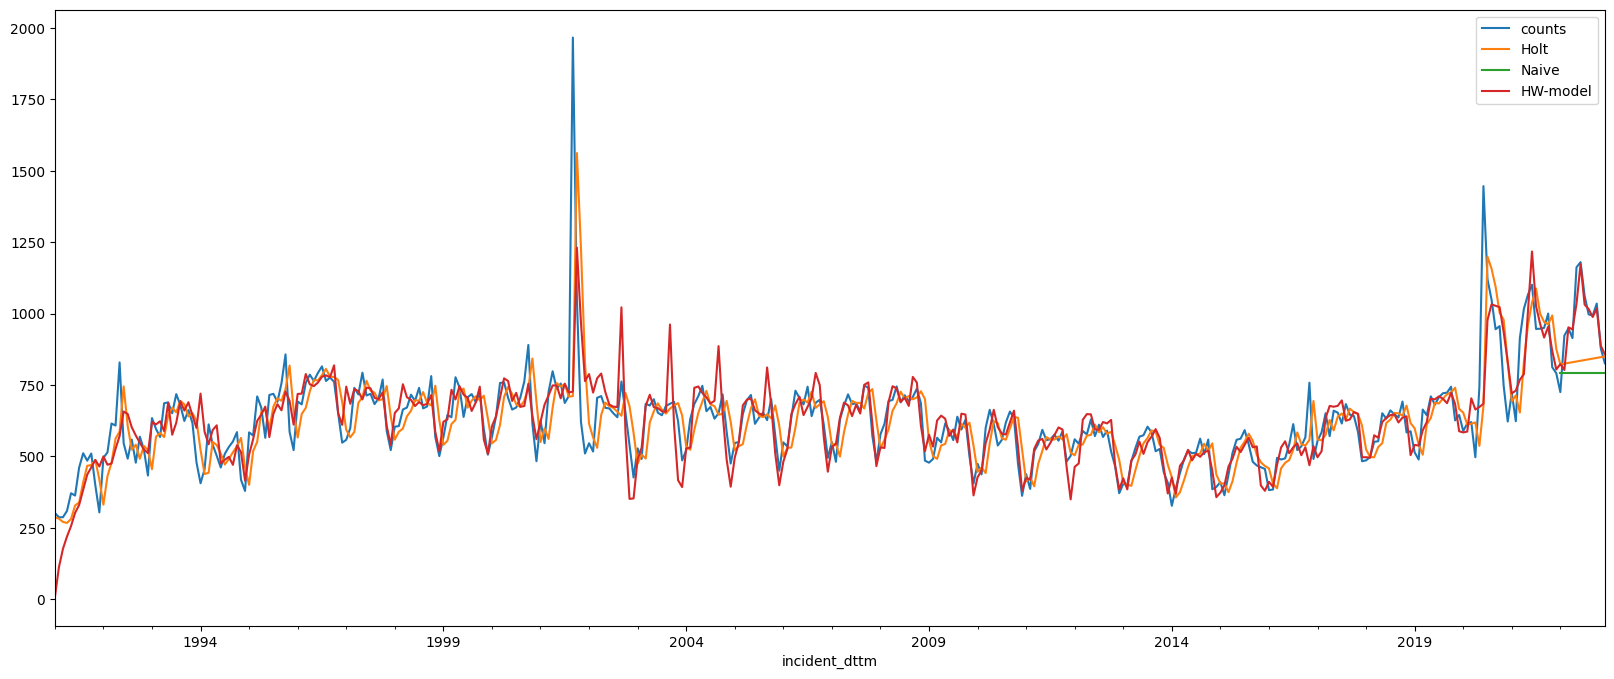

In [375]:
monthly_data[['counts', 'Holt', 'Naive', 'HW-model']].plot(figsize=(20,8))

In [ ]:
# building confidence interals

In [372]:
    # Simulate predictions

    h =12
    n_repetitions = 1000

    yhat = results.forecast(h)
    df_simul = results.simulate(
        nsimulations=h,
        repetitions=n_repetitions,
        anchor='end',
    )

    # Calculate confidence intervals.
    upper_ci = df_simul.quantile(q=0.975, axis='columns')
    lower_ci = df_simul.quantile(q=0.025, axis='columns')

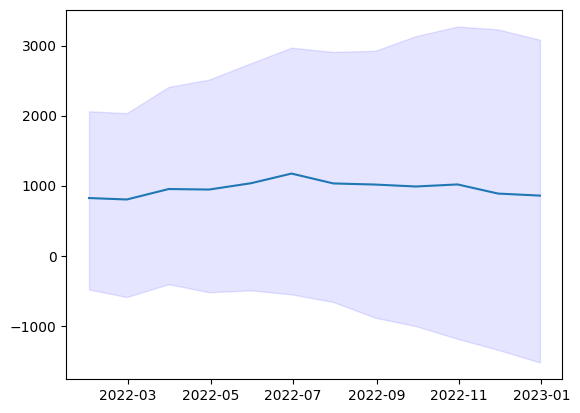

In [374]:
plt.plot(yhat.index, yhat.values)
plt.fill_between(yhat.index, (lower_ci), (upper_ci), color='blue', alpha=.1)

In [352]:
def mape(y_true, y_pred):
  numerator = np.abs(y_true - y_pred)
  denominator = (np.abs(y_true) + np.abs(y_pred))/2
  dividend = numerator/denominator
  return dividend.mean()

In [353]:
mape(test['counts'], fcast)

0.04527869016868788

In [376]:
hw_log = ExponentialSmoothing(train['LogCount'], trend='add', seasonal='add', damped_trend=False, initialization_method='legacy-heuristic', seasonal_periods=12)

In [377]:
results = hw_log.fit()

In [379]:
results.forecast(10).to_numpy()

array([6.65506789, 6.61062053, 6.83111077, 6.80804853, 6.96038331,
       7.09673833, 6.98571261, 6.97449921, 6.94285562, 6.97635909])

In [387]:
log_forecast = np.exp(results.forecast(12))

In [392]:
monthly_data.loc[train_idx, 'LogModel'] = np.exp(results.fittedvalues)
monthly_data.loc[test_idx, 'LogModel'] = log_forecast

In [393]:
monthly_data.tail(12)

,counts,LogCount,boxcox,SMA-6,std-6,ewma-6,ewma-alpha,Holt,Naive,HW-model,LogModel
incident_dttm,,,,,,,,,,,
2022-01-31,725,6.586172,4.202195,870.833333,109.411913,839.868430,849.996936,822.102944,791.0,823.079579,776.710656
2022-02-28,923,6.827629,4.291410,866.833333,106.469557,863.620307,868.247702,824.624952,791.0,802.410677,742.943897
2022-03-31,948,6.854355,4.301090,866.500000,106.159785,887.728791,888.185777,827.146960,791.0,951.629027,926.219061
2022-04-30,914,6.817831,4.287852,852.166667,88.939118,895.234851,894.639333,829.668967,791.0,944.504837,905.102802
2022-05-31,1162,7.057898,4.373563,910.500000,150.676806,971.453465,961.479499,832.190975,791.0,1034.734237,1054.037500
2022-06-30,1180,7.073270,4.378948,975.333333,171.258479,1031.038189,1016.109625,834.712983,791.0,1172.563422,1208.020480
2022-07-31,1062,6.967909,4.341792,1031.500000,120.468668,1039.884421,1027.582218,837.234991,791.0,1031.472585,1081.076533
2022-08-31,997,6.904751,4.319238,1043.833333,110.515911,1027.631729,1019.936664,839.756998,791.0,1015.588860,1069.021704
2022-09-30,993,6.900731,4.317795,1051.333333,104.049347,1017.736949,1013.202498,842.279006,791.0,987.914702,1035.723627


In [394]:
np.sqrt(mean_squared_error(test['counts'], monthly_data.iloc[-Ntest:]['LogModel']))

69.26407999528128

In [395]:
r2_score(test['counts'], monthly_data.iloc[-Ntest:]['LogModel'])

0.6969421702709184

In [ ]:
# Holt Winters model with the boxcox transformation wins